In [1]:
import torch
import torch.nn
import torch.nn.functional as F

In [2]:
from model.encoder import Encoder
from model.transformer import TransformerModel

In [3]:
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

In [4]:
import os
%matplotlib inline
import matplotlib.pyplot as plt
import skimage
from matplotlib import cm
import numpy as np
from dataset import get_data_loader, vocab_size, int2char, char2int, SOS_CHAR, EOS_CHAR, PAD_CHAR
from torchvision import transforms
from utils import ScaleImageByHeight, PaddingWidth, AverageMeter, accuracy

In [5]:
config = {
    'batch_size': 32,
    'hidden_size': 256,
    'attn_size': 256,
    'max_length': 10,
    'n_epochs_decrease_lr': 15,
    'start_learning_rate': 1e-5,  # NOTE: paper start with 1e-8
    'end_learning_rate': 1e-11,
    'depth': 4,
    'n_blocks': 3,
    'growth_rate': 96,
}

In [6]:
MAX_LENGTH = config['max_length']
# CKPT_DIR = './ckpt'
CKPT_DIR = './runs/Jan20_18-46-45_aioz-server/weights/'

In [7]:
info = torch.load(os.path.join(CKPT_DIR, 'BEST_weights.pt'), map_location='cpu')

In [8]:
image_transform = transforms.Compose([
    transforms.Grayscale(3),
    ScaleImageByHeight(64),
    transforms.ToTensor(),
])

In [9]:
test_loader = get_data_loader('test', config['batch_size'], transform=image_transform)

In [10]:
encoder = Encoder(config['depth'], config['n_blocks'], config['growth_rate'])
encoder.load_state_dict(info['encoder'])

<All keys matched successfully>

In [11]:
decoder = TransformerModel(encoder.n_features,
                           vocab_size, config['attn_size'])
decoder.load_state_dict(info['decoder'])

<All keys matched successfully>

In [12]:
encoder = encoder.to(device)
decoder = decoder.to(device)

In [13]:
encoder.eval()
decoder.eval();

In [14]:
test_iter = iter(test_loader)

In [15]:
imgs, targets, targets_onehot, lengths = next(test_iter)

In [16]:
imgs.size()

torch.Size([32, 3, 64, 198])

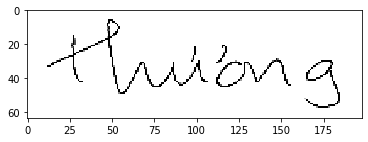

In [17]:
plt.imshow(imgs[0].squeeze().permute(1,2,0))

In [18]:
targets.size()

torch.Size([8, 32, 1])

In [19]:
''.join([int2char[x.item()] for x in targets[:,0].squeeze()])

'<start>thương<end>'

In [21]:
with torch.no_grad():
#     for i, (imgs, targets, targets_onehot, lengths) in enumerate(val_loader):
    imgs = imgs.to(device)
    img_features = encoder(imgs)
    targets_onehot = targets_onehot[1:].to(device)
    targets = targets[1:].to(device)
    lengths = lengths - 1
    outputs = decoder.forward(img_features, targets_onehot, targets, lengths, char2int[PAD_CHAR])

In [22]:
outputs.size()

torch.Size([7, 32, 150])

In [23]:
outputs

tensor([[[-2.1946,  1.1354,  0.3067,  ...,  0.8725,  0.0247, -0.2027],
         [-0.4425,  0.9943,  0.3044,  ...,  0.7033, -0.5946,  0.0844],
         [-0.8920, -0.8265, -1.3722,  ..., -0.1473,  0.5994, -0.4827],
         ...,
         [-0.5644, -1.6868,  0.3291,  ..., -0.0152, -0.5082,  0.7675],
         [-0.5474,  1.0354, -1.9341,  ..., -0.8627,  0.4961, -0.2581],
         [-0.0654,  9.1096, -0.2169,  ..., -0.1455, -0.3403, -0.2406]],

        [[-0.4656,  1.1496,  0.3072,  ...,  0.5679, -0.5584,  0.1206],
         [ 0.5120, -0.0260, -0.2540,  ..., -0.2053, -0.9202, -0.1037],
         [-0.5811,  0.9244,  0.1064,  ...,  0.6968, -0.3223,  0.0885],
         ...,
         [ 0.9775,  0.0904, -0.8025,  ..., -0.0762,  0.3973, -0.6979],
         [ 1.3725, -0.6229, -1.4988,  ..., -0.3934, -0.2073,  0.2013],
         [ 1.7607,  0.3569, -0.9703,  ..., -0.3838, -0.3122,  0.2270]],

        [[-0.8579, -1.0073,  0.2597,  ...,  0.7580, -0.0440,  0.3262],
         [-1.2038,  0.2825, -0.1340,  ...,  0

In [24]:
_, index = outputs.topk(1, -1)

In [25]:
index.size()

torch.Size([7, 32, 1])

In [27]:
predicts = index.squeeze().transpose(0, 1) # [B, T]
predicts

tensor([[ 57,  45,  95,  93,  51,  44,  10],
        [ 45,  58,  61, 121,  51,  10,  45],
        [ 32,  45,  69,  51,  45,  10,  80],
        [ 51,  44,  95, 134,  46,  10, 134],
        [ 57,  76,  51,  45,  10,  10,  10],
        [ 32,  46,  75,  51,  10,  75,  75],
        [ 24,  52,  51,  44,  10,  24,  24],
        [ 32,  46,  75,  51,  10,  75,  75],
        [ 24,  52,  51,  44,  10,  24,  24],
        [ 15,  45,  71,  58,  10,  58,  58],
        [ 66,  51,  44,  10,  10,  10,  10],
        [ 44,  46,  69,  10,  10,  10,  10],
        [ 51,  86,  50,  10,  10,  10,  10],
        [ 49,  69,  50,  10,  10,  10,  10],
        [ 51,  45,  69,  10,  10,  10,  10],
        [ 32,  80,  46,  10,  80,  80,  80],
        [ 44, 110,  53,  10,  53,  53,  53],
        [ 80,  51,  44,  10,  80,  80,  80],
        [ 34,  86,  51,  10,  10,  10,  10],
        [ 32,  70,  50,  10,  70,  70,  70],
        [ 51,  44, 139,  10, 139, 139, 139],
        [ 14, 114,  51,  10,  80,  80,  80],
        [ 

In [28]:
predicts_str = []
for predict in predicts:
    s = [int2char[x.item()] for x in predict]
    try:
        eos_index = s.index(EOS_CHAR) + 1
    except ValueError:
        eos_index = len(s)
    predicts_str.append(s[:eos_index])
predicts_str

[['t', 'h', 'ư', 'ơ', 'n', 'g', '<end>'],
 ['h', 'u', 'y', 'ệ', 'n', '<end>'],
 ['T', 'h', 'à', 'n', 'h', '<end>'],
 ['n', 'g', 'ư', 'ờ', 'i', '<end>'],
 ['t', 'ì', 'n', 'h', '<end>'],
 ['T', 'i', 'ê', 'n', '<end>'],
 ['L', 'o', 'n', 'g', '<end>'],
 ['T', 'i', 'ê', 'n', '<end>'],
 ['L', 'o', 'n', 'g', '<end>'],
 ['C', 'h', 'â', 'u', '<end>'],
 ['Ô', 'n', 'g', '<end>'],
 ['g', 'i', 'à', '<end>'],
 ['n', 'ă', 'm', '<end>'],
 ['l', 'à', 'm', '<end>'],
 ['n', 'h', 'à', '<end>'],
 ['T', 'ô', 'i', '<end>'],
 ['g', 'ặ', 'p', '<end>'],
 ['ô', 'n', 'g', '<end>'],
 ['V', 'ă', 'n', '<end>'],
 ['T', 'á', 'm', '<end>'],
 ['n', 'g', 'ụ', '<end>'],
 ['B', 'ế', 'n', '<end>'],
 ['T', 'r', 'e', '<end>'],
 ['3', '0', '<end>'],
 ['L', 'ê', '<end>'],
 ['u', 'n', '<end>'],
 ['u', 'n', '<end>'],
 ['ấ', 'p', '<end>'],
 ['x', 'ã', '<end>'],
 ['l', 'à', '<end>'],
 ['ở', '<end>'],
 ['1', '<end>']]

# Visualize a sample

In [ ]:
sample_index = 1
sample_image, sample_predict, sample_weigth = imgs[sample_index], predicts_str[sample_index], weights[:, [sample_index]]
fig, axeses = plt.subplots(len(sample_predict), figsize=(15,15), sharex=True, sharey=True)

for i, axes in enumerate(axeses.ravel()):
    weight = weights[i].reshape(-1, config['batch_size'], img_rows // 16, img_cols // 16) # 16 is factor that DenseNet reduce the original image size
    weight_numpy = weight.cpu().numpy()[:,sample_index,:].squeeze()
    weight_image = skimage.transform.resize(weight_numpy, (img_rows, img_cols))
    
    img = sample_image.squeeze().permute(1,2,0).cpu().numpy()[:,:,0]
    
    alpha = 0.5
    blend = img * alpha + weight_image * (1-alpha)
    
    axes.set_title(sample_predict[i])
    axes.imshow(blend, cmap='spring')
plt.plot();

# Calc CER, WER on the test set

## CER

In [29]:
import editdistance as ed

In [30]:
log_test = open('./log_test.txt', 'w+')

In [31]:
total_characters = 0
total_words = 0
CE = 0
WE = 0
log_interval = 10

# t = tqdm(test_loader)
t = test_loader
with torch.no_grad():
    for i, (imgs, targets, targets_onehot, lengths) in enumerate(t):
        print(f'[{i}]/[{len(t)}]', file=log_test)
        log_test.flush()
        batch_size = imgs.size(0)
        
        imgs = imgs.to(device)
        img_features = encoder(imgs)
        targets_onehot = targets_onehot[1:].to(device)
        targets = targets[1:].to(device)
        lengths = lengths - 1
        outputs = decoder.forward(img_features, targets_onehot, targets, lengths, char2int[PAD_CHAR])
        
        _, index = outputs.topk(1, -1)
        predicts = index.squeeze().transpose(0, 1) # [B, T]
        predicts_str = []
        for predict in predicts:
            s = [int2char[x.item()] for x in predict]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            predicts_str.append(s[:eos_index])

        targets_str = []
        for target in targets.transpose(0, 1).squeeze():
            s = [int2char[x.item()] for x in target]
            try:
                eos_index = s.index(EOS_CHAR) + 1
            except ValueError:
                eos_index = len(s)
            targets_str.append(s[:eos_index])
        
        assert len(predicts_str) == len(targets_str)
        for j in range(len(predicts_str)):
            CE += ed.distance(predicts_str[j], targets_str[j])
        total_characters += lengths.sum().item()
        
        for j in range(len(predicts_str)):
            if not np.array_equal(np.array(predicts_str[j]), np.array(targets_str[j])):
                WE += 1
                print(f'Batch {i} - sample {j}: "{predicts_str[j]}"/"{targets_str[j]}"')
        total_words += len(predicts_str)
        
#         t.update()

Batch 0 - sample 25: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 0 - sample 26: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 2 - sample 31: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 8 - sample 31: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 9 - sample 13: "['s', 's', 'n', '<end>']"/"['s', 'ẵ', 'n', '<end>']"
Batch 15 - sample 27: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 16 - sample 26: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 17 - sample 30: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 24 - sample 30: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 28 - sample 21: "['s', 's', 'n', '<end>']"/"['s', 'ẵ', 'n', '<end>']"
Batch 29 - sample 25: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 31 - sample 27: "['M', 'M', '<end>']"/"['M', 'ỹ', '<end>']"
Batch 39 - sample 22: "['u', 'n', '<end>']"/"['O', 'n', '<end>']"
Batch 39 - sample 28: "['k', 'k', '<end>']"/"['k', 'ỳ', '<end>']"
Batch 39 - sample 31: "['y', 'n', '<end>']"/"['Â', 'n', '<end

In [32]:
CER = CE / total_characters
WER = WE / total_words
print('CER', CER, file=log_test)
print('WER', WER, file=log_test)
log_test.flush()

In [33]:
log_test.close()

In [34]:
print(CE, total_characters, CER)

164 108614 0.0015099342626180786


In [35]:
print(WE, total_words, WER)

156 25115 0.0062114274338044995
